# MScFE 642 DEEP LEARNING FOR FINANCE
## Group Work Project # 1
### Student Group 8422
### Yesheng Huang, Atakan Devrent, Mukiza Rayner

In this project, we are aiming to analyze daily prices of the TSLA stock for the last 3 years. Then, we are going to build an **MLP** using the **PyTorch** framework to predict both the prices and log returns of the stock, separately. As our last work, we are going to transform our time series data for **Gramian Angular Field** representation and try to predict the prices and log returns of the stock using **Convolutional Neural Networks**.

## Step 1

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import yfinance as yf
from datetime import date, timedelta
import statsmodels
from statsmodels.tsa.stattools import adfuller
import scipy.stats as stats
import torch
from torch import nn
import torchinfo

We first download our data and select only the **Close** column for daily close prices. Then, we generate log returns to make the time series stationary.

In [2]:
end_date = date(2025, 2, 10)
start_date = date(2022, 2, 10)
ticker = "TSLA"

data = yf.download(ticker, start_date, end_date)
data = data.droplevel(1, axis=1)

# Generate log returns
data["logr"] = data["Close"].apply(np.log).diff()
data.dropna(inplace=True)

# Drop extra columns
data = data.loc[:, ["Close", "logr"]]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


### Step 1.a

    Gather information on the time series of the prices (i.e. the levels) of any security of your choice: equity, cryptocurrencies, options, bonds, volatilities... Provide a characterization of the main properties of that time series: summary statistics about its distribution, persistence, stationarity...

First, we print the last few rows of the data to get an idea of what it looks like.

Then, we show the minimum, maximum, mean and different percentiles of the prices time series.

In [3]:
prices = data["Close"]

print(prices.tail(5))
print("-"*50)
print(prices.describe())

Date
2025-02-03    383.679993
2025-02-04    392.209991
2025-02-05    378.170013
2025-02-06    374.320007
2025-02-07    361.619995
Name: Close, dtype: float64
--------------------------------------------------
count    750.000000
mean     239.115973
std       65.606099
min      108.099998
25%      189.664997
50%      233.068336
75%      267.203331
max      479.859985
Name: Close, dtype: float64


To have a better understanding, we plot the prices against time and then, empirical distribution of prices using a histogram.

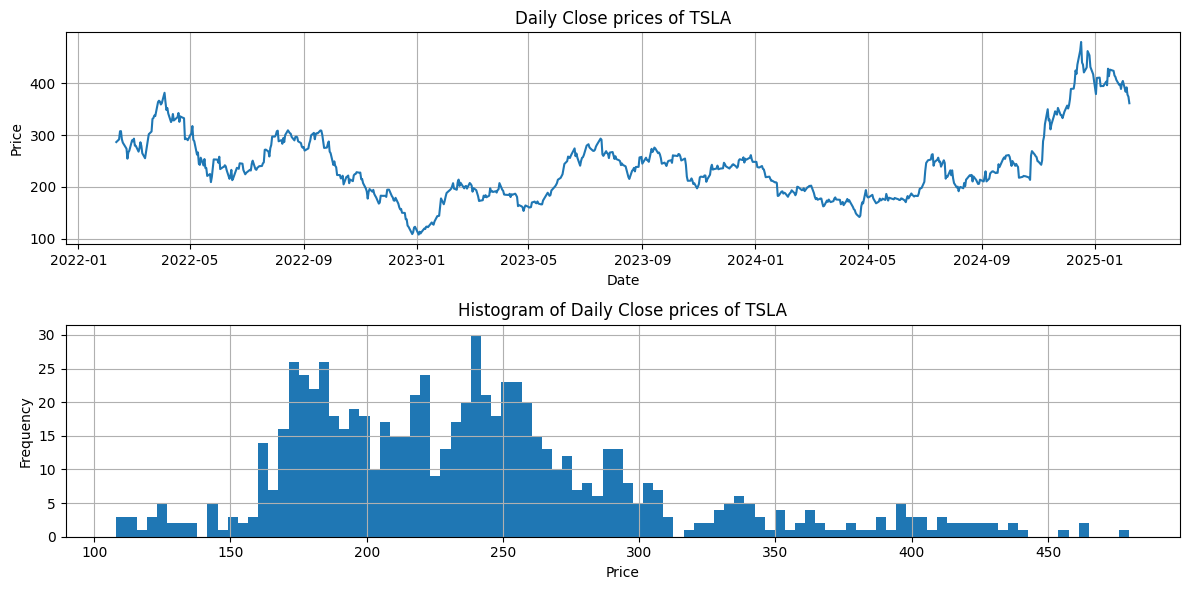

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(prices)
axs[0].set_title("Daily Close prices of TSLA")
axs[0].set_ylabel("Price")
axs[0].set_xlabel("Date")
axs[0].grid()

axs[1].hist(prices, bins=100)
axs[1].set_title("Histogram of Daily Close prices of TSLA")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Price")
axs[1].grid()

fig.tight_layout()

Eye-balling the chart, we can guess that the price of TSLA stock is not stationary. However, to be precise, we apply **Augmented Dickey-Fuller** test to check for stationarity.

In [5]:
adftest = adfuller(prices)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -2.034689
ADF p-value: 0.271573


According to the result of the ADF test, we cannot reject the null hypothesis of non-stationarity. Therefore we conclude our prices time series is not stationary.

### Step 1.b

    Perform the same analysis for a transformed version of the time series that is stationary (e.g. taking first or second differences, taking logs...). To provide arguments about stationarity, you can, for instance, generate visualizations of the time series and use the Augmented Dickey-Fuller (ADF test).

Just like before, we print the last few rows and print the descriptive statistics of our data, however this time the data is the **log returns**.

In [6]:
log_returns = data["logr"]

print(log_returns.tail(5))
print("-"*50)
print(log_returns.describe())

Date
2025-02-03   -0.053090
2025-02-04    0.021989
2025-02-05   -0.036454
2025-02-06   -0.010233
2025-02-07   -0.034517
Name: logr, dtype: float64
--------------------------------------------------
count    750.000000
mean       0.000242
std        0.038236
min       -0.131643
25%       -0.020557
50%        0.001031
75%        0.020897
max        0.198187
Name: logr, dtype: float64


.. and plotting

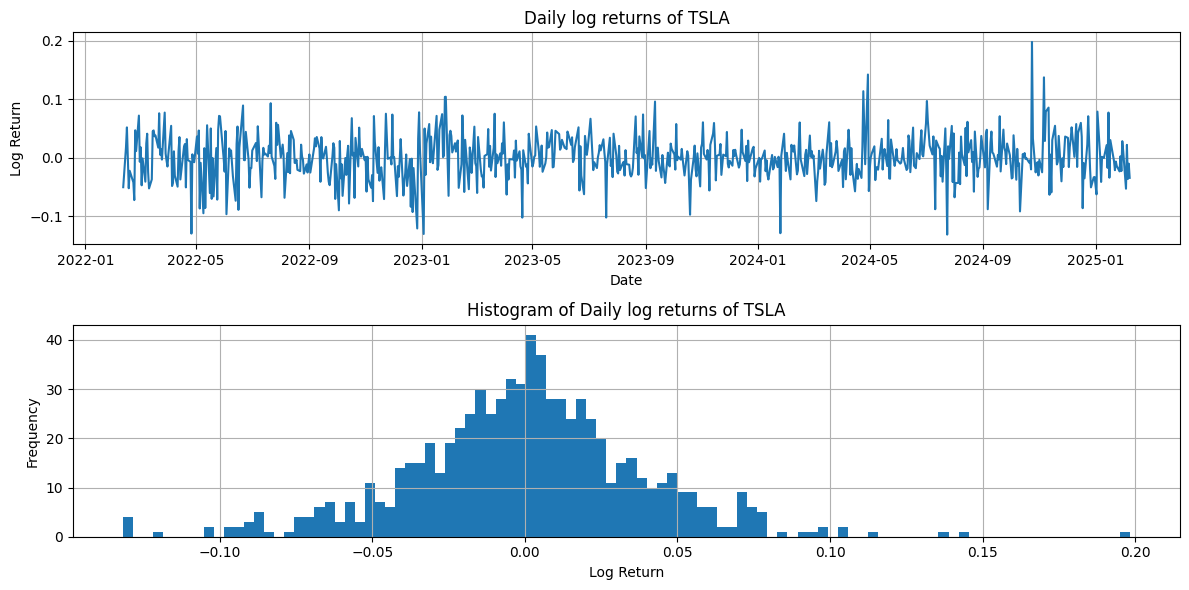

In [7]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(log_returns)
axs[0].set_title("Daily log returns of TSLA")
axs[0].set_ylabel("Log Return")
axs[0].set_xlabel("Date")
axs[0].grid()

axs[1].hist(log_returns, bins=100)
axs[1].set_title("Histogram of Daily log returns of TSLA")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Log Return")
axs[1].grid()

fig.tight_layout()

Looking at the graphs, our time series seems stationary. But to be exact, let's apply an ADF test again.

In [8]:
adftest = adfuller(log_returns)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -7.562219
ADF p-value: 0.000000


With a p-value of $0$, we can confidently reject the null hypothesis and decide that our time series is indeed **stationary**.

Moreover, because we have a stationary distribution and the graph looks like a bell curve, we can also apply a normality test to check if our log returns distribution follows the Gaussian distribution. We are going to use the **Shapiro-Wilk** test:

In [9]:
stat, p_value = stats.shapiro(log_returns)
print("Shapiro-Wilk Test (log returns)")
print(f"Test Statistic: {stat:.4f}, p-value: {p_value:.4g}")

Shapiro-Wilk Test (log returns)
Test Statistic: 0.9817, p-value: 4.368e-08


Because we have a p value of $p \simeq 0$, we reject the null hypothesis of Gaussian distribution with nearly 100% significance and conclude our log returns are <u>not</u> normally distributed.

### Step 1.c

    Use fractional differencing to obtain a new version of the time series that is stationary but retains relevant information about the data. As above, provide a characterization of the main properties of that time series.

Source: https://www.kaggle.com/code/elvisesp/time-series-analysis-using-fractional-differencing/notebook

We use the code from our reference to apply fractional differencing to our **prices** data. Let's use a lag of $30$ to featurize *monthly* past price values. Then, we select the optimal fractional difference parameter $d$ which is maximized with the constraint that our fractional time series is **stationary**.

In [10]:
def getWeights(d,lags):
    # return the weights from the series expansion of the differencing operator
    # for real orders d and up to lags coefficients
    w=[1]
    for k in range(1,lags):
        w.append(-w[-1]*((d-k+1))/k)
    w=np.array(w).reshape(-1,1) 
    return w

def ts_differencing(series, order, lag_cutoff):
    # return the time series resulting from (fractional) differencing
    # for real orders order up to lag_cutoff coefficients
    
    weights=getWeights(order, lag_cutoff)
    res=0
    for k in range(lag_cutoff):
        res += weights[k]*series.shift(k).fillna(0)
    return res[lag_cutoff:]

def optimize_d(series, lags, p_value=0.05):
    # optimize the order of differencing for a given range of lags
    best_d = 0
    best_adf_p = np.inf
    for d in np.linspace(0, 1, 21):
        diff_series = ts_differencing(series, d, lags)
        adf_p = adfuller(diff_series)[1]
        if adf_p < p_value:
            best_adf_p = adf_p
            best_d = d
            print(f"Found d: {best_d}, ADF p-value: {best_adf_p}")
            return best_d

optimum_d = optimize_d(prices, 10)

Found d: 0.5, ADF p-value: 0.02651015887061332


After we have found the optimum $d$ parameter, we create the fractional time series and describe its properties and distribution:

In [11]:
frac_prices = ts_differencing(prices, optimum_d, 10)

print(frac_prices.tail(5))
print("-"*50)
print(frac_prices.describe())

Date
2025-02-03    55.572162
2025-02-04    74.069227
2025-02-05    58.156741
2025-02-06    61.449477
2025-02-07    52.601559
Name: Close, dtype: float64
--------------------------------------------------
count    740.000000
mean      44.465809
std       16.013025
min        4.347030
25%       33.549346
50%       42.153729
75%       51.919070
max      117.316581
Name: Close, dtype: float64


Then we plot the series as usual:

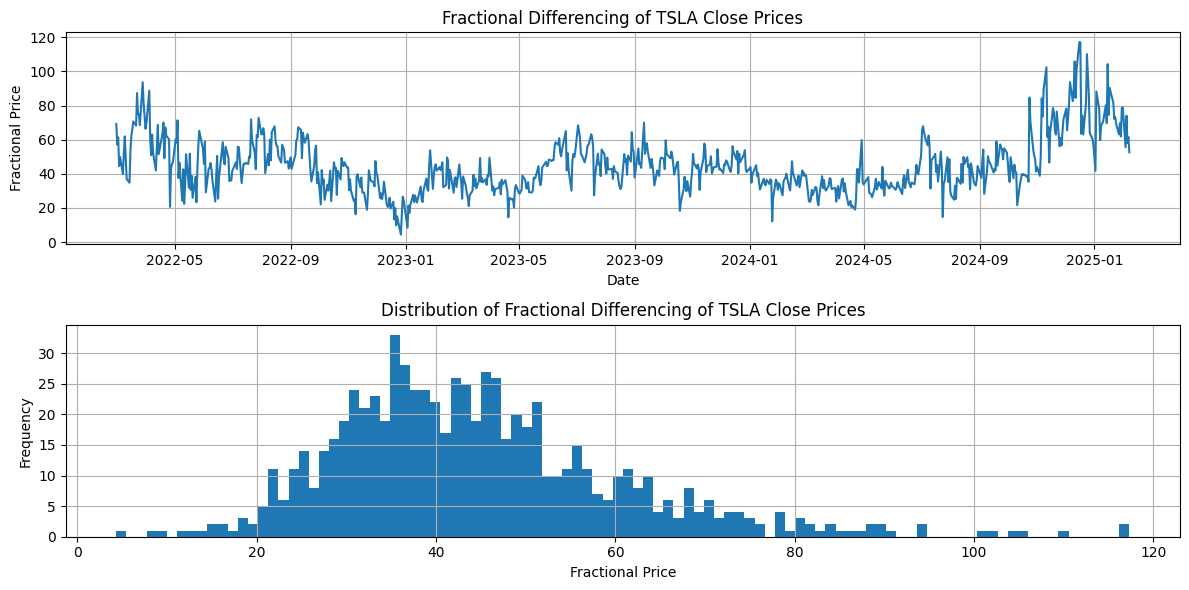

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(frac_prices)
axs[0].set_title("Fractional Differencing of TSLA Close Prices")
axs[0].set_ylabel("Fractional Price")
axs[0].set_xlabel("Date")
axs[0].grid()

axs[1].hist(frac_prices, bins=100)
axs[1].set_title("Distribution of Fractional Differencing of TSLA Close Prices")
axs[1].set_ylabel("Frequency")
axs[1].set_xlabel("Fractional Price")
axs[1].grid()

fig.tight_layout()

And the ADF test as usual:

In [13]:
adftest = adfuller(frac_prices)
print('ADF Statistic: %f' % adftest[0])
print('ADF p-value: %f' % adftest[1])

ADF Statistic: -3.100582
ADF p-value: 0.026510


Although by looking at the plotting we can probably guess that this series is not normally distributed, let's apply a normality test for good measure.

In [14]:
stat, p_value = stats.shapiro(frac_prices)
print("Shapiro-Wilk Test (log returns)")
print(f"Test Statistic: {stat:.4f}, p-value: {p_value:.4g}")

Shapiro-Wilk Test (log returns)
Test Statistic: 0.9459, p-value: 8.356e-16


As expected, our fractional prices time series is not normally distributed according to the Shapiro-Wilk test.

____________

## Step 2

In *Step 2*, we are going to develop a Multi-Layer Perceptron (MLP) to predict our time series that we got in Step 1: **prices** and **log returns**.

We are going to use the N-BEATS architecture by *Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio*, which has proven immense success in prediction problems in univariate time series domain. N-BEATS is a powerful deep learning architecture for time series forecasting because it leverages a simple-to-understand but highly expressive fully connected network without reliance on time-series-specific feature engineering. Its block-based structure, where each block provides both a backcast and a forecast, allows iterative residual learning that improves the prediction increasingly in each iteration. The doubly residual stacking of the novel architecture can propagate gradients successfully and allows the model to decompose the input signal into significant components, such as trend and seasonality, without sacrificing performance. All this is achieved with flexibility, interpretability, and state-of-the-art accuracy on a broad variety of forecasting benchmarks, which makes N-BEATS a compelling choice for time series analysis.



(Reference: https://arxiv.org/abs/1905.10437 - *N-BEATS: Neural basis expansion analysis for interpretable time series forecasting, Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio*)

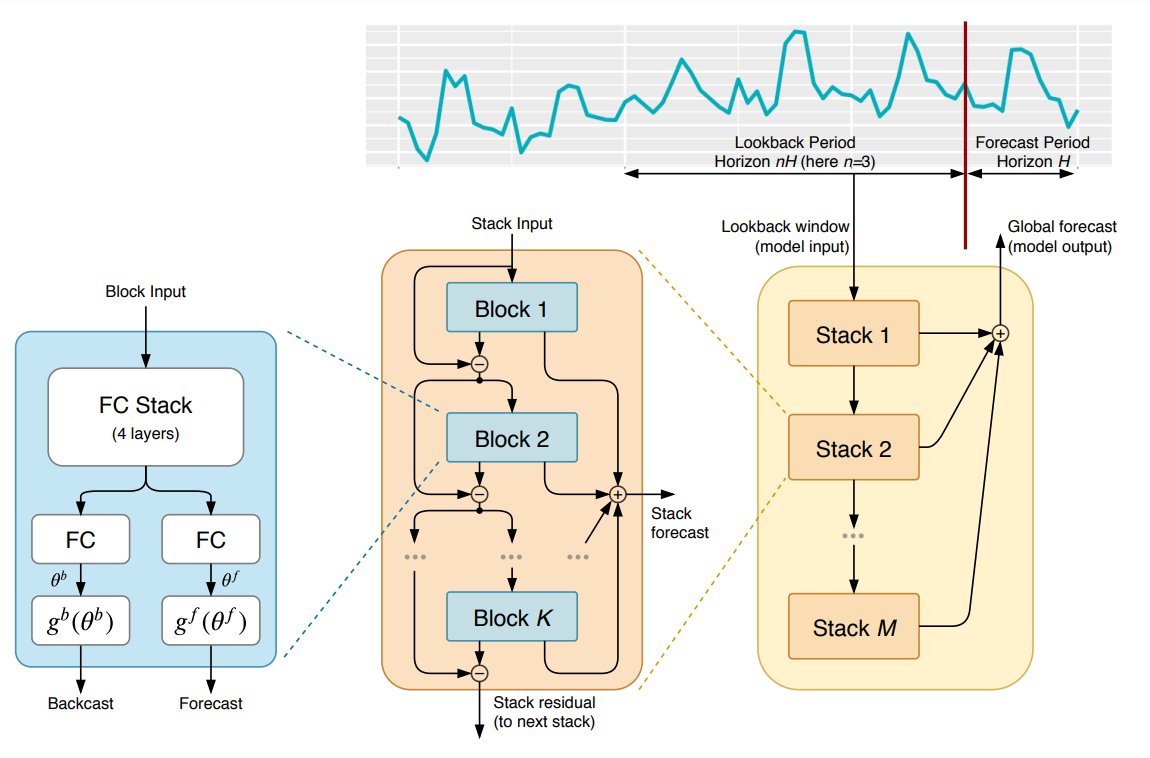

(Reference: https://arxiv.org/abs/1905.10437 - *N-BEATS: Neural basis expansion analysis for interpretable time series forecasting, Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio*)

We first develop the **Block** part of the architecture. We use multiples of $256$ for the hyperparameters of the intermediate layers, as hyperparameter optimization is beyond the scope of this work.

Moreover, we use **Dropout** regularization for intermediate layers, to achieve generalization of our model.

In [15]:
class NBEATSBlock(nn.Module):
    def __init__(self, H, n, dropout_prob=0.1):
        """
        Parameters:
        H (int): Forecast horizon (number of future time steps to predict)
        n (int): How many times the forecast horizon to look back
        """
        super().__init__()
        self.stem = nn.Sequential(  # input size: (batch_size, 1, H*n)
            nn.Linear(in_features=H*n, out_features=512), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(in_features=512, out_features=1024), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(in_features=1024, out_features=512), nn.ReLU(), nn.Dropout(dropout_prob),
            nn.Linear(in_features=512, out_features=256), nn.ReLU()
        )

        # In generic architecture, the backcast and forecast transformations are just linear layers
        self.backcast = nn.Linear(in_features=256, out_features=H*n)
        self.forecast = nn.Linear(in_features=256, out_features=H)

    def forward(self, x):
        x = self.stem(x)
        x_bc = self.backcast(x)
        x_fc = self.forecast(x)

        return x_bc, x_fc

In [16]:
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon

model = NBEATSBlock(H, n)
model.to("cuda")
torchinfo.summary(model, input_size=(1, H*n))

Layer (type:depth-idx)                   Output Shape              Param #
NBEATSBlock                              [1, 50]                   --
├─Sequential: 1-1                        [1, 256]                  --
│    └─Linear: 2-1                       [1, 512]                  26,112
│    └─ReLU: 2-2                         [1, 512]                  --
│    └─Dropout: 2-3                      [1, 512]                  --
│    └─Linear: 2-4                       [1, 1024]                 525,312
│    └─ReLU: 2-5                         [1, 1024]                 --
│    └─Dropout: 2-6                      [1, 1024]                 --
│    └─Linear: 2-7                       [1, 512]                  524,800
│    └─ReLU: 2-8                         [1, 512]                  --
│    └─Dropout: 2-9                      [1, 512]                  --
│    └─Linear: 2-10                      [1, 256]                  131,328
│    └─ReLU: 2-11                        [1, 256]                 

Then, we develop the **Stack** part of the architecture, using our Blocks. *nn.Sequential* is designed to compose modules in a highly linear, feed-forward manner where the output of one module is automatically passed on as the input for the next. Because our **NBEATSStack** contains blocks that produce two outputs (*forecast* and *backcast*), we need to manually update the residual by subtracting the backcast from the input before passing it to the next block. This kind of custom control flow and multiple outputs handling is impossible with *nn.Sequential*, thus we use the class *nn.ModuleList*.

In [17]:
class NBEATSStack(nn.Module):
    def __init__(self, K, H, n):
        """
        Parameters:
        K (int): Number of blocks in the stack
        H (int): Forecast horizon (number of future time steps to predict)
        n (int): How many times the forecast horizon to look back
        """
        super().__init__()
        self.blocks = nn.ModuleList([NBEATSBlock(H, n) for _ in range(K)])

    def forward(self, x):
        x_fc_sum = torch.zeros(x.size(0), H, dtype=x.dtype).to(x.device)
        residual = x  # start with the original input
        for block in self.blocks:
            x_bc, x_fc = block(residual)
            residual = residual - x_bc  # update residual using the block’s input
            x_fc_sum += x_fc
        return residual, x_fc_sum

In [18]:
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon
K = 30  # Number of blocks in the stack

model = NBEATSStack(K, H, n)
model.to("cuda")
torchinfo.summary(model, input_size=(1, H*n))

Layer (type:depth-idx)                   Output Shape              Param #
NBEATSStack                              [1, 50]                   --
├─ModuleList: 1-1                        --                        --
│    └─NBEATSBlock: 2-1                  [1, 50]                   --
│    │    └─Sequential: 3-1              [1, 256]                  1,207,552
│    │    └─Linear: 3-2                  [1, 50]                   12,850
│    │    └─Linear: 3-3                  [1, 10]                   2,570
│    └─NBEATSBlock: 2-2                  [1, 50]                   --
│    │    └─Sequential: 3-4              [1, 256]                  1,207,552
│    │    └─Linear: 3-5                  [1, 50]                   12,850
│    │    └─Linear: 3-6                  [1, 10]                   2,570
│    └─NBEATSBlock: 2-3                  [1, 50]                   --
│    │    └─Sequential: 3-7              [1, 256]                  1,207,552
│    │    └─Linear: 3-8                  [1, 50]  

Finally, we develop the highest level of the hierarcy; putting individuals stacks on top of each other to finalize our network architecture:

In [19]:
class NBEATS(nn.Module):
    def __init__(self, M, K, H, n):
        """
        Parameters:
        M (int): Number of stacks in the network
        K (int): Number of blocks in the stack
        H (int): Forecast horizon (number of future time steps to predict)
        n (int): How many times the forecast horizon to look back
        """
        super().__init__()
        self.H = H
        self.stacks = nn.ModuleList([NBEATSStack(K, H, n) for _ in range(M)])
    
    def forward(self, x):
        # Initialize forecast accumulator
        forecast_total = torch.zeros(x.size(0), self.H, 
                                  device=x.device, dtype=x.dtype)
        residual = x
        
        for stack in self.stacks:
            # Process through stack
            residual, stack_forecast = stack(residual)
            # Aggregate forecasts
            forecast_total += stack_forecast
            
        return forecast_total

In [20]:
M = 3 # Number of stacks in the network
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon
K = 30  # Number of blocks in the stack

model = NBEATS(M, K, H, n)
model.to("cuda")
torchinfo.summary(model, input_size=(1, H*n))

Layer (type:depth-idx)                        Output Shape              Param #
NBEATS                                        [1, 10]                   --
├─ModuleList: 1-1                             --                        --
│    └─NBEATSStack: 2-1                       [1, 50]                   --
│    │    └─ModuleList: 3-1                   --                        36,689,160
│    └─NBEATSStack: 2-2                       [1, 50]                   --
│    │    └─ModuleList: 3-2                   --                        36,689,160
│    └─NBEATSStack: 2-3                       [1, 50]                   --
│    │    └─ModuleList: 3-3                   --                        36,689,160
Total params: 110,067,480
Trainable params: 110,067,480
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 110.07
Input size (MB): 0.00
Forward/backward pass size (MB): 1.70
Params size (MB): 440.27
Estimated Total Size (MB): 441.97

Now, we advance to the training part. Because our model has more than 100 million parameters, it is pretty data-hungry, so for training and validation we increase our data size and download TSLA price data between the years $2012 - 2022$ as our train/validation split. Then, the last 3 years of data is going to be a complete test set, which is the same data as the plotted data in Step 1.

In [21]:
end_date = date(2022, 2, 10)
start_date = date(2012, 2, 10)
ticker = "TSLA"

trainval_data = yf.download(ticker, start_date, end_date)

end_date = date(2025, 2, 10)
start_date = date(2022, 2, 10)
test_data = yf.download(ticker, start_date, end_date)

trainval_data = trainval_data.droplevel(1, axis=1)
test_data = test_data.droplevel(1, axis=1)

# Generate log returns
trainval_data["logr"] = trainval_data["Close"].apply(np.log).diff()
trainval_data.dropna(inplace=True)

test_data["logr"] = test_data["Close"].apply(np.log).diff()
test_data.dropna(inplace=True)

# Drop extra columns
trainval_data = trainval_data.loc[:, ["Close", "logr"]]
test_data = test_data.loc[:, ["Close", "logr"]]

print()
print("-"*50)
print()
print("Train/Validation Data")
print(trainval_data.info())
print()
print(trainval_data.tail(5))
print()
print("-"*50)
print()
print("Test Data")
print(test_data.info())
print()
print(test_data.tail(5))
print()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


--------------------------------------------------

Train/Validation Data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2012-02-13 to 2022-02-09
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2516 non-null   float64
 1   logr    2516 non-null   float64
dtypes: float64(2)
memory usage: 59.0 KB
None

Price            Close      logr
Date                            
2022-02-03  297.046661 -0.016162
2022-02-04  307.773346  0.035474
2022-02-07  302.446655 -0.017459
2022-02-08  307.333344  0.016028
2022-02-09  310.666656  0.010788

--------------------------------------------------

Test Data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 750 entries, 2022-02-11 to 2025-02-07
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   750 non-null    float64
 1   logr    750 non-null    float64
dtypes: float64(2)
memory usage: 17.6 KB


Then, we featurize our dataset with labels: for every day, previous $H \times n$ trading days will be used as features, and the next $H$ days will be used as labels.

We'll show our steps on the **Prices** data, then we are going to apply the same logic to the **Log Returns** data.

In [22]:
def featurize_series_NBEATS(series, H, n):
    """
    Parameters:
    series (pd.Series): Time series to convert to PyTorch tensor
    H (int): Forecast horizon (number of future time steps to predict)
    n (int): How many times the forecast horizon to look back
    """
    series = series.values.astype(np.float32)

    # Create the feature tensor X by rolling the series n times
    num_rows = len(series) - H*n - H + 1
    X = np.zeros((num_rows, H*n))
    Y = np.zeros((num_rows, H))
    for i in range(num_rows):
        X[i, :] = series[i : i + H*n]
        Y[i, :] = series[i + H*n : i + H*n + H]

    X = torch.tensor(X, dtype=torch.float32)
    Y = torch.tensor(Y, dtype=torch.float32)

    return X, Y

H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon

X, Y = featurize_series_NBEATS(trainval_data["Close"], H, n)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print(X.dtype)
print(Y.dtype)

X shape: torch.Size([2457, 50])
Y shape: torch.Size([2457, 10])
torch.float32
torch.float32


Then, we split our dataset into training and validation parts and choose $v=0.2$ as our validation ratio.

In [23]:
def train_val_split(X, Y, val_size=0.2):
    """
    Parameters:
    X (torch.Tensor): Input feature tensor
    Y (torch.Tensor): Target tensor
    val_size (float): Proportion of the data to use for validation
    """
    num_train = int((1-val_size) * len(X))
    X_train, Y_train = X[:num_train], Y[:num_train]
    X_val, Y_val = X[num_train:], Y[num_train:]

    return X_train, Y_train, X_val, Y_val

X_train, Y_train, X_val, Y_val = train_val_split(X, Y, val_size=0.2)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)

X_train shape: torch.Size([1965, 50])
Y_train shape: torch.Size([1965, 10])
X_val shape: torch.Size([492, 50])
Y_val shape: torch.Size([492, 10])


Then we initialize PyTorch *TensorDataset* and *DataLoader* objects to prepare our dataset for training, choosing a **batch size** of $32$.

In [24]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32
train_dataset = TensorDataset(X_train, Y_train)
val_dataset   = TensorDataset(X_val, Y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

We not initialize the model for training. As time series forecasting is inherently a regression problem, choosing *Mean Squared Error (MSE)* as loss function is suitable. Moreover, we pick *ADAM* as our optimizer.

In [25]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

M = 3 # Number of stacks in the network
K = 30  # Number of blocks in the stack
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon

# Initialize model
model = NBEATS(M, K, H, n).to(device)

# Choose loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Using device: cuda


After initialization, we develop our training loop and train our model. We keep track of the loss at each epoch and then, because we have more than 100 million trainable parameters, save our model weights to disk.

Moreover, we utilize **early stopping** for regularization and improving training performance, with a **patience** parameter of $10$, such that if validation loss does not improve for 10 epochs, we terminate the training process and save the best model parameters to disk.

Epoch 1/100 - Train Loss: 513.2505 - Val Loss: 640.1078
    Best model weights so far saved to best_nbeats_price_model.pth
Epoch 2/100 - Train Loss: 3.2806 - Val Loss: 989.5349
Epoch 3/100 - Train Loss: 2.7216 - Val Loss: 647.0216
Epoch 4/100 - Train Loss: 2.5310 - Val Loss: 521.2210
    Best model weights so far saved to best_nbeats_price_model.pth
Epoch 5/100 - Train Loss: 2.1078 - Val Loss: 482.3641
    Best model weights so far saved to best_nbeats_price_model.pth
Epoch 6/100 - Train Loss: 2.2623 - Val Loss: 568.8278
Epoch 7/100 - Train Loss: 2.0299 - Val Loss: 515.2614
Epoch 8/100 - Train Loss: 1.9607 - Val Loss: 603.2154
Epoch 9/100 - Train Loss: 1.9148 - Val Loss: 932.9791
Epoch 10/100 - Train Loss: 1.8803 - Val Loss: 582.0145
Epoch 11/100 - Train Loss: 2.0560 - Val Loss: 594.1493
Epoch 12/100 - Train Loss: 1.8209 - Val Loss: 575.5637
Epoch 13/100 - Train Loss: 2.1628 - Val Loss: 531.3823
Epoch 14/100 - Train Loss: 2.1577 - Val Loss: 477.2058
    Best model weights so far saved 

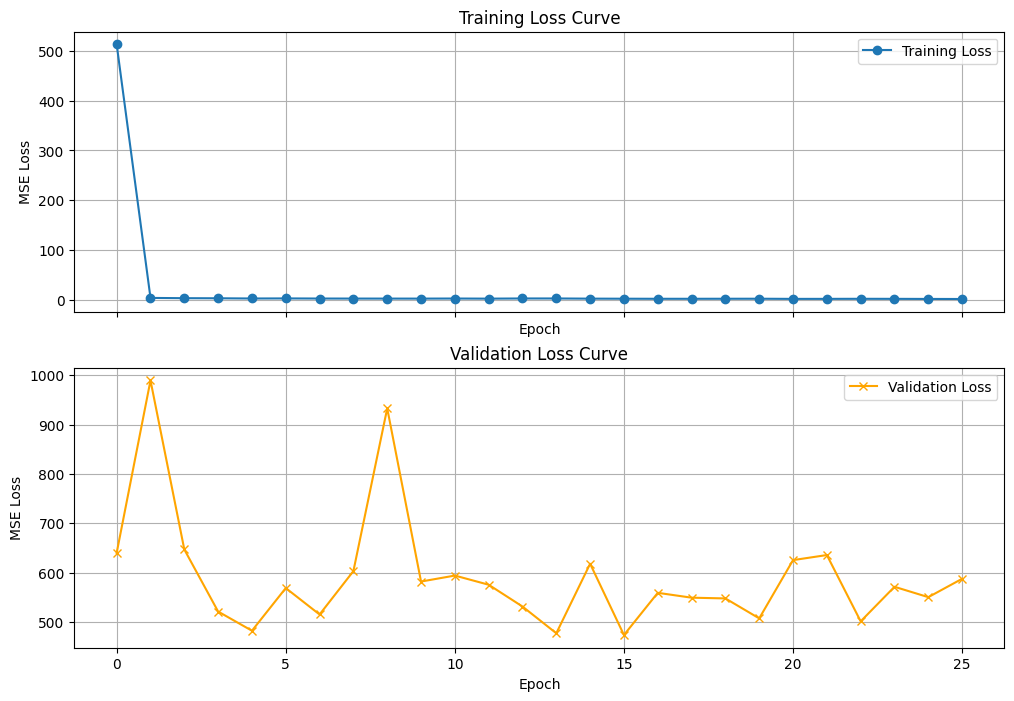

In [26]:
def train_NBEATS(train_loader, val_loader, model, loss_func, optimizer, device, feature="prices"):
    num_epochs = 100
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience = 10
    epochs_without_improve = 0

    if feature == "prices":
        save_path_best = "best_nbeats_price_model.pth"
        save_path_final = "nbeats_price_model_weights_final.pth"
    else:
        save_path_best = "best_nbeats_logr_model.pth"
        save_path_final = "nbeats_logr_model_weights_final.pth"

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        running_train_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)   # shape: (batch_size, H*n)
            targets = targets.to(device)   # shape: (batch_size, H)
            
            optimizer.zero_grad()
            forecasts = model(inputs)      # forecast shape: (batch_size, H)
            loss = loss_func(forecasts, targets)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation loop
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                forecasts = model(inputs)
                loss = loss_func(forecasts, targets)
                running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
        
        # Early stopping: check if validation loss improved
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            epochs_without_improve = 0
            # Optionally save the best model here
            torch.save(model.state_dict(), save_path_best)
            print(f"    Best model weights so far saved to {save_path_best}")
        else:
            epochs_without_improve += 1
            if epochs_without_improve >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs.")
                break

    # Save the final model weights
    torch.save(model.state_dict(), save_path_final)
    print(f"    Final model weights saved to {save_path_final}")

    # Plot the training and validation loss curves
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].plot(train_losses, marker='o', label="Training Loss")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("MSE Loss")
    axs[0].set_title("Training Loss Curve")
    axs[0].legend()
    axs[0].grid()

    axs[1].plot(val_losses, marker='x', color='orange', label="Validation Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("MSE Loss")
    axs[1].set_title("Validation Loss Curve")
    axs[1].legend()
    axs[1].grid()

train_NBEATS(train_loader, val_loader, model, loss_func, optimizer, device, feature="prices")

After finishing training, let us test the model using our test dataset, by loading the best training weights.

Using device: cuda
Loaded best model weights from best_nbeats_price_model.pth
X_test shape: torch.Size([691, 50])
Y_test shape: torch.Size([691, 10])
Test MSE Loss: 912.4221


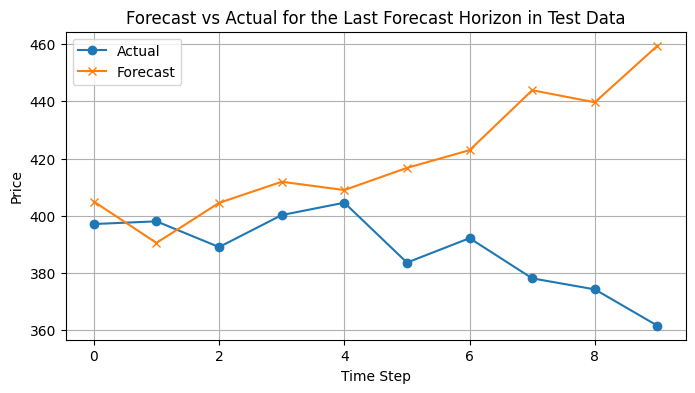

In [27]:
H = 10  # forecast horizon
n = 5   # lookback multiplier
M = 3   # number of stacks
K = 30  # number of blocks per stack

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize the model architecture and load best weights
model = NBEATS(M, K, H, n).to(device)
model.load_state_dict(torch.load("best_nbeats_price_model.pth", map_location=device))
model.eval()
print("Loaded best model weights from best_nbeats_price_model.pth")

# Featurize the test series using the same H and n as training
test_series = test_data["Close"]
X_test, Y_test = featurize_series_NBEATS(test_series, H, n)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

# Move test data to device (we'll work on the whole tensor here for simplicity)
X_test = X_test.to(device)
Y_test = Y_test.to(device)

# Compute forecasts on the test set
with torch.no_grad():
    forecasts_test = model(X_test)  # shape: (num_samples, H)

# Compute test loss (MSE)
test_loss = nn.MSELoss()(forecasts_test, Y_test).item()
print(f"Test MSE Loss: {test_loss:.4f}")

# For visualization, let's plot the last forecast sample:
# We'll take the last sample from the test set, which corresponds to the last available forecast horizon.
last_forecast = forecasts_test[-1].cpu().numpy()
last_target = Y_test[-1].cpu().numpy()

plt.figure(figsize=(8, 4))
plt.plot(range(H), last_target, marker='o', label="Actual")
plt.plot(range(H), last_forecast, marker='x', label="Forecast")
plt.xlabel("Time Step")
plt.ylabel("Price")
plt.title("Forecast vs Actual for the Last Forecast Horizon in Test Data")
plt.legend()
plt.grid(True)
plt.show()

After our test results, we apply all of the above steps for the log returns dataset also.

X_logr shape: torch.Size([2457, 50])
Y_logr shape: torch.Size([2457, 10])
Using device: cuda
Epoch 1/100 - Train Loss: 0.0077 - Val Loss: 0.0023
    Best model weights so far saved to best_nbeats_logr_model.pth
Epoch 2/100 - Train Loss: 0.0015 - Val Loss: 0.0023
Epoch 3/100 - Train Loss: 0.0014 - Val Loss: 0.0025
Epoch 4/100 - Train Loss: 0.0014 - Val Loss: 0.0023
Epoch 5/100 - Train Loss: 0.0014 - Val Loss: 0.0023
Epoch 6/100 - Train Loss: 0.0014 - Val Loss: 0.0023
Epoch 7/100 - Train Loss: 0.0014 - Val Loss: 0.0023
Epoch 8/100 - Train Loss: 0.0014 - Val Loss: 0.0026
Epoch 9/100 - Train Loss: 0.0014 - Val Loss: 0.0024
Epoch 10/100 - Train Loss: 0.0014 - Val Loss: 0.0022
    Best model weights so far saved to best_nbeats_logr_model.pth
Epoch 11/100 - Train Loss: 0.0013 - Val Loss: 0.0023
Epoch 12/100 - Train Loss: 0.0013 - Val Loss: 0.0023
Epoch 13/100 - Train Loss: 0.0014 - Val Loss: 0.0025
Epoch 14/100 - Train Loss: 0.0012 - Val Loss: 0.0023
Epoch 15/100 - Train Loss: 0.0012 - Val Lo

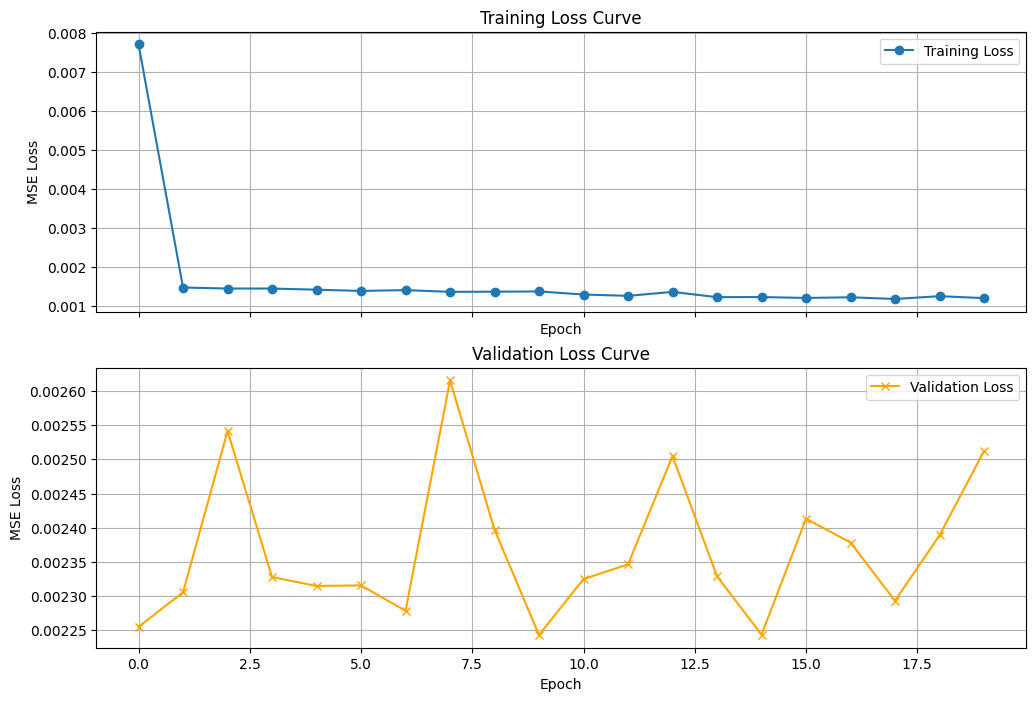

In [28]:
logr_series = trainval_data["logr"]

# Featurize the log returns series
X_logr, Y_logr = featurize_series_NBEATS(logr_series, H, n)
print("X_logr shape:", X_logr.shape)
print("Y_logr shape:", Y_logr.shape)

# Split into training and validation sets
X_train_logr, Y_train_logr, X_val_logr, Y_val_logr = train_val_split(X_logr, Y_logr, val_size=0.2)

# Create DataLoaders
batch_size = 32
train_dataset_logr = TensorDataset(X_train_logr, Y_train_logr)
val_dataset_logr = TensorDataset(X_val_logr, Y_val_logr)

train_loader_logr = DataLoader(train_dataset_logr, batch_size=batch_size, shuffle=True)
val_loader_logr   = DataLoader(val_dataset_logr, batch_size=batch_size, shuffle=False)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

M = 3 # Number of stacks in the network
K = 30  # Number of blocks in the stack
H = 10  # Forecast horizon
n = 5  # Look back n times the forecast horizon

# Initialize model
model = NBEATS(M, K, H, n).to(device)

# Choose loss function and optimizer
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Call training function with feature="logr"
train_NBEATS(train_loader_logr, val_loader_logr, model, loss_func, optimizer, device, feature="logr")

As we can see, our model is underperforming under the log returns data. This might be because by making the time series stationary, we have effectively removed information that might have been useful for training our parameters.